<a href="https://colab.research.google.com/github/jayro0414/house_price_prediction/blob/main/House_Prediction_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
import tensorflow as tf


Importing Data

In [5]:
data = pd.read_csv("kc_house_data.csv")
data = data.reset_index()

Exploring Data

In [6]:
data

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7.0,1180.0,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7.0,2170.0,400.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0
2,2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6.0,770.0,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0
3,3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7.0,1050.0,910.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0
4,4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8.0,1680.0,0.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19018,19018,8651400230,20141208T000000,225000.0,3,2.00,1100,5200,1.0,0,0,3,6.0,1100.0,0.0,1969.0,2014.0,98042.0,47.3606,-122.083,1050.0,5330.0
19019,19019,7437100210,20140618T000000,315000.0,3,2.50,1730,6368,2.0,0,0,3,7.0,1730.0,0.0,1993.0,0.0,98038.0,47.3505,-122.032,1780.0,6597.0
19020,19020,3630020150,20150310T000000,425000.0,3,2.50,1480,1386,3.0,0,0,3,8.0,1480.0,0.0,2005.0,0.0,98029.0,47.5468,-121.998,1470.0,1593.0
19021,19021,1773600691,20140625T000000,346500.0,3,1.00,1150,11802,1.0,0,0,4,7.0,1150.0,0.0,1932.0,1958.0,98106.0,47.5624,-122.361,1880.0,6082.0


In [7]:
data.describe()

,index,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,19023.000000,1.902300e+04,1.902300e+04,19023.000000,19023.000000,19023.000000,1.902300e+04,19023.000000,19023.000000,19023.000000,19023.000000,19022.000000,19020.000000,19022.000000,19022.000000,19022.000000,19022.000000,19022.000000,19022.000000,19022.000000,19022.000000
mean,9511.000000,4.567832e+09,5.342769e+05,3.361773,2.061005,2051.043947,1.573746e+04,1.432582,0.008095,0.244914,3.449088,7.592209,1748.466404,302.584797,1967.177531,91.590527,98078.124750,47.560450,-122.215495,1971.540690,13254.794606
std,5491.611421,2.862649e+09,3.663961e+05,0.934684,0.759904,903.393123,4.208193e+04,0.509931,0.089612,0.783194,0.667700,1.170447,806.095310,449.158484,27.993074,417.633064,54.088349,0.139535,0.138965,672.003841,27155.253872
min,0.000000,1.000102e+06,7.500000e+04,0.000000,0.000000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,660.000000
25%,4755.500000,2.124049e+09,3.150000e+05,3.000000,1.500000,1410.000000,5.440000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1180.000000,0.000000,1949.000000,0.000000,98033.000000,47.466400,-122.327000,1490.000000,5413.000000
50%,9511.000000,3.905101e+09,4.490000e+05,3.000000,2.000000,1890.000000,7.897000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1530.000000,0.000000,1969.000000,0.000000,98065.000000,47.573500,-122.232000,1830.000000,7804.500000
75%,14266.500000,7.295200e+09,6.371250e+05,4.000000,2.500000,2500.000000,1.109100e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2130.000000,600.000000,1990.000000,0.000000,98118.000000,47.679200,-122.127000,2330.000000,10303.000000
max,19022.000000,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6110.000000,871200.000000


Data Visualizaiton

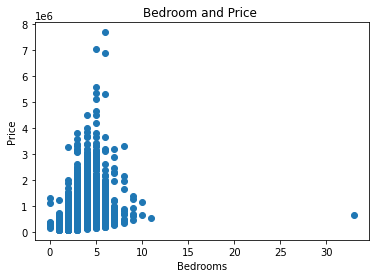

<function seaborn.utils.despine>

In [8]:
plt.scatter(data.bedrooms,data.price)
plt.title("Bedroom and Price ")
plt.xlabel("Bedrooms")
plt.ylabel("Price")
plt.show()
sns.despine

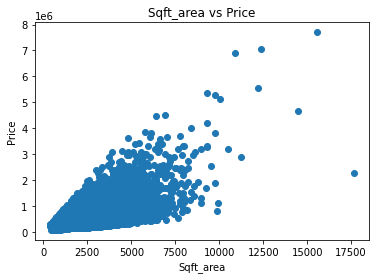

In [25]:
plt.scatter((data['sqft_living']+data['sqft_basement']),data['price'])
plt.xlabel("Sqft_area")
plt.ylabel("Price")
plt.title("Sqft_area vs Price")
plt.show()

Text(0.5, 1.0, 'Waterfront vs Price (0= no waterfront)')

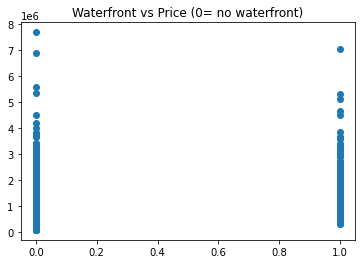

In [24]:
plt.scatter(data.waterfront,data.price)
plt.title("Waterfront vs Price (0= no waterfront)")

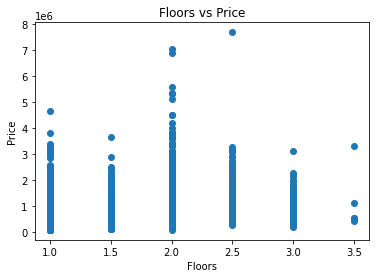

In [23]:
plt.scatter(data.floors,data.price)
plt.xlabel("Floors")
plt.ylabel("Price")
plt.title("Floors vs Price")
plt.show()

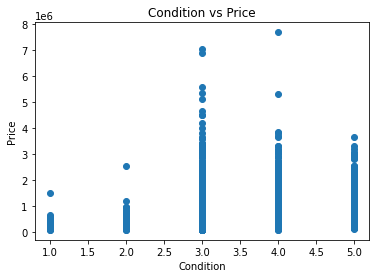

In [22]:
plt.scatter(data.condition,data.price)
plt.xlabel("Condition")
plt.ylabel("Price")
plt.title("Condition vs Price")
plt.show()

Cleaning Data

In [13]:
# Drop columns that contain information on traits that are not related to the house
data = data.drop(columns=['id','index'])
data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [14]:
# Determine columns that contain null values
data.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            1
sqft_above       3
sqft_basement    1
yr_built         1
yr_renovated     1
zipcode          1
lat              1
long             1
sqft_living15    1
sqft_lot15       1
dtype: int64

In [15]:
# Since there are insignificant number of rows that contain null values, those rows will be dropped
data.dropna(axis=0, inplace=True)

In [16]:
#Determining and dropping categorical variables

s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['date']


In [17]:
drop_data = data.select_dtypes(exclude=['object'])
drop_data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7.0,1180.0,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7.0,2170.0,400.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6.0,770.0,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7.0,1050.0,910.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8.0,1680.0,0.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19017,3800000.0,3,4.25,5510,35000,2.0,0,4,3,13.0,4910.0,600.0,1997.0,0.0,98177.0,47.7296,-122.370,3430.0,45302.0
19018,225000.0,3,2.00,1100,5200,1.0,0,0,3,6.0,1100.0,0.0,1969.0,2014.0,98042.0,47.3606,-122.083,1050.0,5330.0
19019,315000.0,3,2.50,1730,6368,2.0,0,0,3,7.0,1730.0,0.0,1993.0,0.0,98038.0,47.3505,-122.032,1780.0,6597.0
19020,425000.0,3,2.50,1480,1386,3.0,0,0,3,8.0,1480.0,0.0,2005.0,0.0,98029.0,47.5468,-121.998,1470.0,1593.0


Choosing the best model

In [18]:
#Splitting dependent and independent variables
y = data.price

X = drop_data.drop(['price'],axis=1)

In [26]:
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Function for comparing different models and determining the best model and parameters
# Linear Regression
def optimal_parameter(X,y):
  algorithm = {
      'linear_regression' : {
          'model': LinearRegression(),
          'params':{
              'fit_intercept': [True, False]
          }
      }
  }
  scores = []
  cv = cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
  for algo, config in algorithm.items():
    gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
    gs.fit(X,y)
    scores.append({
        'model': algo,
        'best_score': gs.best_score_,
        'best_params': gs.best_params_
    })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
optimal_parameter(X,y)

,model,best_score,best_params
0,linear_regression,0.70727,{'fit_intercept': True}


In [27]:
# Decision Tree
def optimal_parameter(X,y):
  algorithm = {
      'decision_tree': {
          'model': DecisionTreeRegressor(),
          'params': {
              'criterion': ['squared_error', 'friedman_mse'],
              'splitter': ['best', 'random']
          }
      }
  }
  scores = []
  cv = cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
  for algo, config in algorithm.items():
    gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
    gs.fit(X,y)
    scores.append({
        'model': algo,
        'best_score': gs.best_score_,
        'best_params': gs.best_params_
    })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
optimal_parameter(X,y)

,model,best_score,best_params
0,decision_tree,0.715876,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [29]:
# Random Forest
def optimal_parameter(X,y):
  algorithm = {
      'random_forest': {
          'model': RandomForestRegressor(),
          'params': {
              'n_estimators': np.arange(10,50, 10),
              'criterion': ['squared_error', 'friedman_mse']
          }
      }
  }
  scores = []
  cv = cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
  for algo, config in algorithm.items():
    gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
    gs.fit(X,y)
    scores.append({
        'model': algo,
        'best_score': gs.best_score_,
        'best_params': gs.best_params_
    })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
optimal_parameter(X,y)

,model,best_score,best_params
0,random_forest,0.861465,"{'criterion': 'friedman_mse', 'n_estimators': 40}"


Comapring the scores, random forest produces the best result
